# Stardist+Unet

#### How to Use

1. To run demo data, click the three run buttons '▷' in order
2. To run you own data, allow Google Drive request while runing the first cell, and replace 'Source_image' path with your ***tif*** file path.

##### How to replace file path
1. Click the folder button '🗂️' on the left. Click 'drive', and find data at your google drive. Click '⋮' button on the right of you file. Click 'copy path', and then paste it on the second cell



In [59]:
%%capture
#@markdown ##Initilization and Model Loading(Take up to 3 mins)
!pip install gputools > /dev/null 2>&1
!pip install stardist > /dev/null 2>&1
!pip install -q fpdf2 > /dev/null 2>&1

import numpy as np
from stardist import fill_label_holes, random_label_cmap, calculate_extents, gputools_available, relabel_image_stardist, random_label_cmap,  relabel_image_stardist, _draw_polygons, export_imagej_rois
from stardist.models import Config2D, StarDist2D, StarDistData2D
from csbdeep.utils import Path, normalize
import skimage
import pandas as pd
import csv
import time
from tifffile import imread, imwrite
from csbdeep.utils import normalize
from stardist.models import StarDist2D
from stardist import random_label_cmap
import tensorflow as tf

from torch.utils.data import DataLoader, random_split
import os
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import torch.nn.utils.prune as prune

import torch
import torch.nn as nn
import torch.nn.functional as F
import time
from tqdm import tqdm
import numpy as np

from torch.utils.data import Dataset
from PIL import Image, ImageOps

import requests
import zipfile
import io
from glob import glob

from collections import Counter
from matplotlib.patches import Patch
from scipy import ndimage
import cv2
a = input('Do you want to connect to Google Drive to use your own data?(y/n)')
if a.lower() == 'y' or a.lower() == 'yes':
    from google.colab import drive
    drive.mount('/content/drive')

# Unet Structure

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class Down(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

class Up(nn.Module):
    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=False, learn = 0.005):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)

        self.optimizer = torch.optim.Adam(self.parameters(), lr=learn)

        self.history = {"train_loss": [], "val_loss": []}

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

    def ce_loss(self, pred_mask, target_mask, weighted=False):
        target_mask = target_mask.squeeze(1).type(torch.long)
        if weighted:
            weight = torch.ones(pred_mask.shape[1], device=self.device)
            weight[0] = 10
            weight[1] = 10
            weight[2] = 10
            loss = F.cross_entropy(pred_mask, target_mask, weight=weight)
        else:
            loss = F.cross_entropy(pred_mask, target_mask)
        return loss

    def focal_loss(self, inputs, targets, alpha=0.25, gamma=2.0, epsilon=1e-9):
        inputs = F.softmax(inputs, dim=1)
        targets = targets.squeeze(1)  # [batch_size, 1, height, width] to [batch_size, height, width]
        targets = F.one_hot(targets, num_classes=inputs.shape[1]).permute(0, 3, 1, 2).float()

        inputs = inputs.clamp(min=epsilon, max=1.0 - epsilon)
        pt = torch.where(torch.eq(targets, 1), inputs, 1 - inputs)
        loss = -alpha * (1 - pt) ** gamma * torch.log(pt)

        return loss.mean()

    def dice_loss(self, inputs, targets, smooth=1e-6):
        inputs = F.softmax(inputs, dim=1)
        targets = targets.squeeze(1)
        targets = F.one_hot(targets, num_classes=inputs.shape[1]).permute(0, 3, 1, 2).float()

        intersection = 2.0 * (inputs * targets).sum(dim=(2, 3))
        union = inputs.sum(dim=(2, 3)) + targets.sum(dim=(2, 3))
        dice_score = (intersection + smooth) / (union + smooth)

        return (1 - dice_score).mean()

    def combined_loss(self, inputs, targets, alpha=0.5, beta=0.5, gamma=2.0, smooth=1e-6):
        loss_focal = self.focal_loss(inputs, targets, alpha=alpha, gamma=gamma)
        loss_dice = self.dice_loss(inputs, targets, smooth=smooth)
        return beta * loss_focal + (1 - beta) * loss_dice


    def train_step(self, inputs, target_mask, lossfunc):
        inputs, target_mask = inputs.to(self.device), target_mask.to(self.device)
        self.train()
        self.optimizer.zero_grad()
        pred_mask = self(inputs)
        mask_loss = lossfunc(pred_mask, target_mask)

        mask_loss.backward()
        self.optimizer.step()
        return mask_loss.item()

    def validate(self, val_loader, lossfunc):
        self.eval()
        total_loss = 0
        with torch.no_grad():
            for inputs, target_mask in val_loader:
                target_mask = target_mask.long()
                inputs, target_mask = inputs.to(device), target_mask.to(device)
                pred_mask = self(inputs)
                mask_loss = lossfunc(pred_mask, target_mask)
                total_loss += mask_loss.item()
        return total_loss / len(val_loader)

    def train_model(self, full_dataset, epochs, batch_size, val_percent, loss='dice_loss'):
        alloss = {'dice_loss': self.dice_loss, 'focal_loss': self.focal_loss,
                  'combined_loss': self.combined_loss, 'ce_loss': self.ce_loss}
        lossfunc = alloss[loss]

        for epoch in range(epochs):
            start_time = time.time()

            n_val = int(len(full_dataset) * val_percent)
            n_train = len(full_dataset) - n_val
            train_subset, val_subset = torch.utils.data.random_split(full_dataset, [n_train, n_val])

            train_loader = torch.utils.data.DataLoader(train_subset, batch_size=batch_size, shuffle=True)
            val_loader = torch.utils.data.DataLoader(val_subset, batch_size=batch_size)

            total_train_loss = 0
            for inputs, target_mask in train_loader:
                target_mask = target_mask.long()
                mask_loss = self.train_step(inputs, target_mask, lossfunc)
                total_train_loss += mask_loss
            avg_train_loss = total_train_loss / len(train_loader)
            self.history["train_loss"].append(avg_train_loss)

            end_time = time.time()
            elapsed_time = end_time - start_time

            if val_loader:
                avg_val_loss = self.validate(val_loader, lossfunc)
                self.history["val_loss"].append(avg_val_loss)
            else:
                avg_val_loss = 'N/A'

            print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {avg_train_loss}, Val Loss: {avg_val_loss} Time: {elapsed_time:.2f} sec")

            if torch.cuda.is_available():
                torch.cuda.empty_cache()

    def predict(self, x):
        x = x.to(self.device)
        self.eval()
        with torch.no_grad():
            preds = self(x)
            preds = preds.argmax(dim=1)  #  (batch_size, height, width)

            preds = preds.float() / (self.n_classes - 1) * 255
            preds = preds.to(torch.uint8)

            return preds

    def save_model(self, file_path):
        torch.save(self.state_dict(), file_path)

    @staticmethod
    def load_model(file_path, n_channels, n_classes, bilinear=False):
        model = UNet(n_channels, n_classes, bilinear)
        model.load_state_dict(torch.load(file_path, map_location=model.device))
        return model

class BasicDataset(Dataset):
    def __init__(self, images_dir, masks_dir, augmentation=False, mirror=True, rotate=True):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.augmentation = augmentation

        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.1),
        ])
        self.transtensor = transforms.ToTensor()

        self.images = [file for file in os.listdir(images_dir) if file.endswith('.png')]
        self.masks = [file for file in os.listdir(masks_dir) if file.endswith('.png')]

        if self.augmentation:
            self.apply_augmentation(mirror, rotate)

    def apply_augmentation(self, mirror, rotate):
        for img_name in self.images:
            img_path = os.path.join(self.images_dir, img_name)
            image = Image.open(img_path).convert("L")

            if mirror:
                mirrored_image = ImageOps.mirror(image)
                mirrored_image.save(os.path.join(self.images_dir, f'mirror_{img_name}'))

            if rotate:
                rotated_image = image.rotate(180)
                rotated_image.save(os.path.join(self.images_dir, f'rotate_{img_name}'))

        for mask_name in self.masks:
            mask_path = os.path.join(self.masks_dir, mask_name)
            mask = Image.open(mask_path).convert("L")

            if mirror:
                mirrored_mask = ImageOps.mirror(mask)
                mirrored_mask.save(os.path.join(self.masks_dir, f'mirror_{mask_name}'))

            if rotate:
                rotated_mask = mask.rotate(180)
                rotated_mask.save(os.path.join(self.masks_dir, f'rotate_{mask_name}'))

        # Update the lists of images and masks after augmentation
        self.images = [file for file in os.listdir(self.images_dir) if file.endswith('.png')]
        self.masks = [file for file in os.listdir(self.masks_dir) if file.endswith('.png')]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.images_dir, self.images[idx])
        mask_path = os.path.join(self.masks_dir, self.masks[idx])

        image = Image.open(img_path).convert("L")
        mask = Image.open(mask_path).convert("L")

        if self.transform:
            image = self.transform(image)
        else:
            image = self.transtensor(image)

        mask = torch.from_numpy(np.array(mask))

        return image, mask

# Define the Zenodo link
zenodo_link = "https://zenodo.org/records/10683423/files/model2.zip?download=1"
#model1:"https://zenodo.org/records/10655519/files/starunet.zip?download=1"
#model2:"https://zenodo.org/records/10683423/files/model2.zip?download=1"
# Download the file
response = requests.get(zenodo_link)
zip_file = zipfile.ZipFile(io.BytesIO(response.content))

# Specify the destination folder for extraction
destination_folder = '/content' + "/model"


# Extract the contents of the zip file to the destination folder
zip_file.extractall(destination_folder)

# Close the zip file
zip_file.close()

!rm -rf model/__MACOSX/

zenodo_link = "https://zenodo.org/records/10656286/files/small.tif?download=1"
response = requests.get(zenodo_link)

destination_path = '/content/demo.tif'

with open(destination_path, 'wb') as file:
    file.write(response.content)

Do you want to connect to Google Drive to use your own data?(y/n)n


In [60]:
# %%capture

Source_image = "/content/demo.tif"  #@param{type:"string"}
Stardist_probability_threshold = 0.65 #@param{type:"number"}
# preprocess
import tifffile as tiff

def process_tiff(file_path):
    img = tiff.imread(file_path)

    if img.ndim == 4:
        channel_data = img[:, :, :, 0]

        if channel_data.dtype == np.uint16:
            channel_data = (channel_data / 256).astype(np.uint8)

        processed_file_path = file_path.replace('.tif', '_processed.tif')
        tiff.imwrite(processed_file_path, channel_data)

        return processed_file_path

    elif img.ndim == 3:
        img = img[:, :, 0]
        if img.dtype == np.uint16:
            img = (img / 256).astype(np.uint8)
            processed_file_path = file_path.replace('.tif', '_processed.tif')
            tiff.imwrite(processed_file_path, img)
            return processed_file_path
        else:
            return file_path
    elif img.ndim == 2:
        if img.dtype == np.uint16:
            img = (img / 256).astype(np.uint8)
            return processed_file_path
        else:
            return file_path

Source_image = process_tiff(Source_image)

#split video

if Source_image.split('.')[-1] == 'tif':
    img = tiff.TiffFile(Source_image).asarray()
else:
    img = cv2.imread(Source_image, cv2.IMREAD_UNCHANGED)

save_folder = 'processing'

if not os.path.exists(save_folder):
    os.makedirs(save_folder)

if len(img.shape) == 3:
    for t in range(img.shape[0]):
        frame = img[t, :, :]
        frame_filename = os.path.join(save_folder, f'frame_{t}.png')
        cv2.imwrite(frame_filename, frame)
elif len(img.shape) == 2:
    frame = img.copy()
    frame_filename = os.path.join(save_folder, f"{Source_image.split('/')[-1]}")
    cv2.imwrite(frame_filename, frame)


# Stardist
Source_images_folder = '/content/processing'
close_processing_images = True #@param{type:"boolean"}

def starpre(folder):
    base_path = '/content/model/model2'
    # m1: /content/model/starunet m2:/content/model/model2
    model_name = 'star2'
    save_folder = os.path.join(base_path, model_name, "Predictions")

    if not os.path.exists(save_folder):
        os.makedirs(save_folder)

    Source_QC_folder_tif = os.path.join(folder, "[!\\.]*")
    Z = sorted(glob(Source_QC_folder_tif))
    file_paths = Z.copy()
    Z = list(map(imread, Z)) if Z[0].split('.')[-1] == 'tif' else [skimage.io.imread(str(file_path)) for file_path in Z]
    n_channel = 1 if Z[0].ndim == 2 else Z[0].shape[-1]

    model = StarDist2D(None, name=model_name, basedir=base_path)
    axis_norm = (0, 1) if n_channel == 1 else (0, 1, 2)
    lbl_cmap = random_label_cmap()

    loaded_model = tf.saved_model.load(os.path.join(base_path, model_name))

    for i, img in tqdm(enumerate(Z), total=len(Z)):
        img_normalized = normalize(img, 1, 99.8, axis=axis_norm)
        prob_threshold = Stardist_probability_threshold
        labels, _ = model.predict_instances(img_normalized, prob_thresh=prob_threshold)

        fig, ax = plt.subplots(1, 3, figsize=(18, 6))

        ax[0].imshow(img, cmap='gray')
        ax[0].set_title('Original Image')
        ax[0].axis('off')

        ax[1].imshow(labels, cmap=lbl_cmap)
        ax[1].set_title('Predicted Mask')
        ax[1].axis('off')

        ax[2].imshow(img, cmap='gray')
        ax[2].imshow(labels, cmap=lbl_cmap, alpha=0.5)  # 重叠预测掩码，透明度设置为0.5
        ax[2].set_title('Overlap')
        ax[2].axis('off')

        if close_processing_images:
          plt.close()
        # plt.show()
        # print(file_paths[i])

        filename = os.path.basename(file_paths[i])
        imwrite(os.path.join(save_folder, filename), labels)

starpre(Source_images_folder)

def unetpre(image_dir, model):
    base_path = '/content/model/model2'
    QC_model_name = 'unet2'
    save_folder = os.path.join(base_path, QC_model_name, "Predictions")

    if not os.path.exists(save_folder):
        os.makedirs(save_folder)

    transform = transforms.Compose([
        transforms.ToTensor(),
    ]) #        transforms.Resize((256, 256)),
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    for filename in tqdm(os.listdir(image_dir)):
        if filename.endswith('.png'):
            image_path = os.path.join(image_dir, filename)
            image = Image.open(image_path).convert('L')
        elif filename.endswith('.tif'):
            image_path = os.path.join(image_dir, filename)
            image = skimage.io.imread(image_path)

        input_image = transform(image).unsqueeze(0).to(device)

        model.eval()
        with torch.no_grad():
            prediction = model(input_image)
            prediction = prediction.argmax(dim=1).squeeze(0).cpu().numpy()

        prediction_to_save = prediction.astype(np.uint8)
        imwrite(os.path.join(save_folder, filename), prediction_to_save)

        fig, axes = plt.subplots(1, 3, figsize=(15, 5))

        axes[0].imshow(np.array(image), cmap='gray')
        axes[0].set_title('Original Image')
        axes[0].axis('off')

        axes[1].imshow(prediction, cmap='CMRmap_r')
        axes[1].set_title('Predicted Image')
        axes[1].axis('off')

        axes[2].imshow(np.array(image), cmap='gray', alpha=1)
        axes[2].imshow(prediction, cmap='CMRmap_r', alpha=0.5)
        axes[2].set_title('Overlap')
        axes[2].axis('off')

        if close_processing_images:
            plt.close()
        #plt.show()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
unetmodel = UNet.load_model("/content/model/model2/unet2/unet.pth", n_channels=1, n_classes=4)
unetmodel = unetmodel.to(device)
unetpre(Source_images_folder, model = unetmodel)


Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.639463, nms_thresh=0.3.


100%|██████████| 52/52 [27:38<00:00, 31.89s/it]


100%|██████████| 52/52 [02:00<00:00,  2.33s/it]


counts.csv data saved


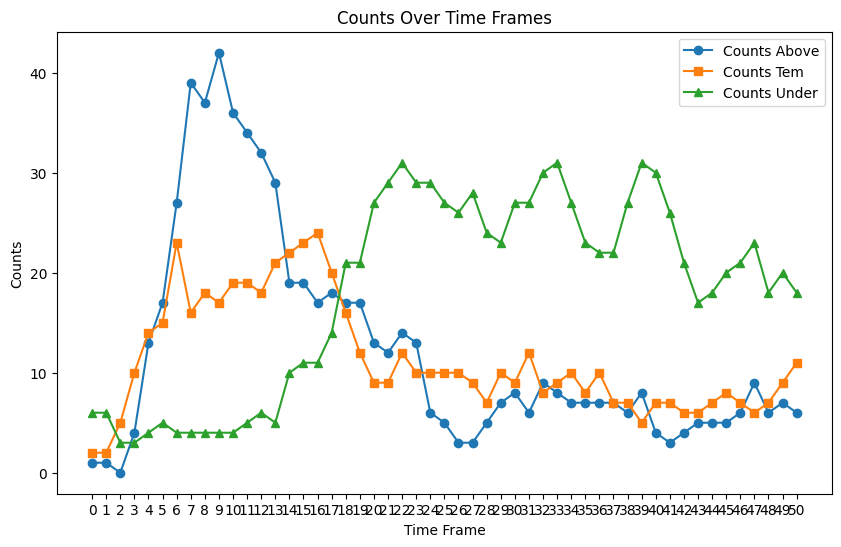

video saved asoutput_video.tif


In [61]:
close_processing_data = True #@param{type:"boolean"}
close_result_iamges = True #@param{type:"boolean"}


import re
def sort_key(name):
    numbers = re.findall(r'\d+', name)
    return int(numbers[0]) if numbers else 0

def count_dir(dir_path, save_dir, ori_save_dir, line_thickness=3):
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    if not os.path.exists(ori_save_dir):
        os.makedirs(ori_save_dir)

    color_map = {'above': 'red', 'tem': 'blue', 'under': 'green'}
    color_map2 = {1: (255, 0, 0), 2: (0, 0, 255), 3: (0, 255, 0)}
    legend_elements = [Patch(facecolor=color, edgecolor=color, label=f'Label {label}') for label, color in color_map.items()]

    counts = {'counts_above':[], 'counts_tem':[], 'counts_under':[]}
    map = {1:'count_above', 2:'count_tem', 3:'count_under'}

    sorted_filenames = sorted(os.listdir(dir_path), key=sort_key)

    for filename in tqdm(sorted_filenames):
        if filename.startswith('.'):
            continue
        count = {'count_above':0, 'count_tem':0, 'count_under':0} # above label is 1, tem label is 2, under label is 3
        image_path = os.path.join(dir_path, filename)

        image_star = np.array(Image.open(f'/content/model/model2/star2/Predictions/{filename}'))
        image_unet = np.array(Image.open(f'/content/model/model2/unet2/Predictions/{filename}'))
        original_image = np.array(Image.open(image_path).convert('RGB'))
        #print(f'orignal cells: {max(np.unique(image_star))}')

        original_image_with_ori_boundary = np.array(Image.open(image_path).convert('RGB'))
        '''
        for i in range(1, np.max(image_star) + 1):
            mask_ori = (image_star == i)
            boundary_ori = ndimage.binary_dilation(mask_ori) ^ mask_ori
            original_image_with_ori_boundary[boundary_ori] = [255, 255, 255]  # 白色边界

        plt.figure()
        plt.imshow(original_image_with_ori_boundary)
        plt.axis('off')
        plt.savefig(os.path.join(ori_save_dir, filename), bbox_inches='tight')
        plt.close()
        '''
        for index, cells in enumerate(np.unique(image_star)):

            mask = (image_star == index)
            labels_in_region = image_unet[mask]
            label_counts = Counter(labels_in_region)
            top_three = label_counts.most_common(5)

            '''
            total_count = sum(label_counts.values())
            print(f"Region {i} in {filename}:")
            for label, count in top_three:
                percentage = (count / total_count) * 100
                print(f"  Label {label}: {count} ({percentage:.2f}%)")
            '''

            for label, _ in top_three:
                if label not in [0, 4]:
                    #print(top_three,label,)
                    count[map[label]] += 1
                    dilation = ndimage.binary_dilation(mask)
                    erosion = ndimage.binary_erosion(mask)
                    boundary = dilation ^ erosion
                    #boundary = ndimage.binary_dilation(mask) ^ mask
                    color = color_map2.get(label, (255, 255, 255))
                    tag = f"{index}_{map[label]}"

                    y, x = np.where(boundary)
                    max_y, max_x = y.max(), x.max()

                    cv2.putText(original_image, tag, (max_x, max_y), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,255,255), 1, cv2.LINE_AA)

                    # print(f"{tag}, {map[label]} +1, color is {color}")
                    original_image[boundary] = color
                    #original_image[boundary] = cv2.cvtColor(np.uint8([[[color]]]), cv2.COLOR_RGB2BGR)[0][0]
                    break
                '''
                else:
                    boundary = ndimage.binary_dilation(mask) ^ mask
                    color = (0, 0, 255)
                    original_image[boundary] = cv2.cvtColor(np.uint8([[[color]]]), cv2.COLOR_RGB2BGR)[0][0]'''

        if not close_processing_data:
            print(f'{filename}:{count}')
        #print(f'after cells: {sum(count.values())}')


        fig, ax = plt.subplots()
        ax.imshow(original_image)
        # ax.legend(handles=legend_elements, loc='lower left')
        ax.axis('off')
        count_text = "\n".join([f'Label {label}: {count}' for label, count in count.items()])
        plt.text(0.95, 0.05, count_text, verticalalignment='bottom', horizontalalignment='right', transform=ax.transAxes, color='white', fontsize=6, alpha = 0.5)

        # Save image
        plt.savefig(os.path.join(save_dir, filename), bbox_inches='tight', dpi=200)
        if close_result_iamges:
            plt.close()
        else:
            plt.show()

        counts['counts_above'].append(count['count_above'])
        counts['counts_tem'].append(count['count_tem'])
        counts['counts_under'].append(count['count_under'])

    df = pd.DataFrame(counts)
    df.index.name = 'time frame'

    csv_filename = 'counts.csv'
    df.to_csv(csv_filename)

    print(f'counts.csv data saved')

    if not close_processing_data:
        print(counts)

    return counts

counts = count_dir(Source_images_folder, '/content/results/images', '/content/results/oris')


df = pd.read_csv('counts.csv', index_col='time frame')

plt.figure(figsize=(10, 6))
plt.plot(df['counts_above'], label='Counts Above', marker='o')
plt.plot(df['counts_tem'], label='Counts Tem', marker='s')
plt.plot(df['counts_under'], label='Counts Under', marker='^')

plt.title('Counts Over Time Frames')
plt.xlabel('Time Frame')
plt.ylabel('Counts')
plt.xticks(range(len(df)))
plt.legend()
plt.show()

def create_tif_video(folder_path, output_filename):
    frames = []
    file_list = sorted([f for f in os.listdir(folder_path) if f.endswith('.png')], key=lambda x: int(x.split('_')[1].split('.')[0]))

    for file in file_list:
        file_path = os.path.join(folder_path, file)
        frame = Image.open(file_path)
        frames.append(frame)

    frames[0].save(output_filename, save_all=True, append_images=frames[1:], duration=100, loop=0)
    print(f'video saved as{output_filename}')

folder_path = '/content/results/images'
output_filename = 'output_video.tif'

create_tif_video(folder_path, output_filename)
